In [2]:
from centersdisplaying import *
from os import listdir
from os.path import isfile, join
import re
import numpy as np
from import_images import import_images_from_path
from cellmask_model import CellMaskModel
import os
import matplotlib.pyplot as plt
import torch
import cv2
import time
import pickle

In [10]:
#import the cell_centers2.txt file without numpy
with open("cell_centers", "rb") as fp:   # Unpickling
    cell_centers = pickle.load(fp)
cell_centers = [[(item[0], item[1]) for item in arr] for arr in cell_centers]

#import the images#
images = np.array(import_images_from_path('data/',num_imgs=3,normalisation=True))

model = CellMaskModel()
model.import_model('saved_weights/cp_model', 'saved_weights/mask_model')
#cps, masks, instance_masks = model.eval(images) #Making predictions

#Let's import the ground truth instance masks which are npy files
instance_masks_path = str('data_for_cellpose\\')
onlyfiles = [f for f in listdir(instance_masks_path) if isfile(join(instance_masks_path, f)) and f.endswith('.npy')]
onlyfiles.sort(key=lambda f: int(re.sub('\D', '', f))) #sort the files in order
gt_instance_masks = [np.load(instance_masks_path + onlyfiles[i], allow_pickle=True).item()['masks'] for i in range(len(onlyfiles))]
gt_instance_masks = gt_instance_masks[:3]

#start = time.time()
encodings_cp = get_encodings(images, model, encoder_type='cp')
encodings_mk = get_encodings(images, model, encoder_type='mask')

#I want to get the encodings from both encoders
#Then I want to average them together

encFeats_per_cell_per_mask_cp = get_encFeats_per_cell_per_mask(gt_instance_masks, encodings_cp)
#print(encFeats_per_cell_per_mask_cp[0])
encFeats_per_cell_per_mask_mk = get_encFeats_per_cell_per_mask(gt_instance_masks, encodings_mk)

#print(encFeats_per_cell_per_mask_mk.shape)
cos_sims_per_cell_masks_encFeats_cp = get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask_cp)
cos_sims_per_cell_masks_encFeats_mk = get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask_mk)
cos_sims_per_cell_masks_encFeats_mean = np.mean([cos_sims_per_cell_masks_encFeats_cp, cos_sims_per_cell_masks_encFeats_mk], axis=0)

c:\Users\rz200\Documents\development\cellprobabilityUNet\cellmask\centersdisplaying.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encFeats_per_cell_per_mask = np.array(encFeats_per_cell_per_mask)


In [106]:
def get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask):
    cos_sims_for_each_cell = []
    for cell_encFeats in encFeats_per_cell_per_mask[0]:
        cos_sims_for_cell = []
        arr1 = cell_encFeats.flatten()
        for cell_encFeats2 in encFeats_per_cell_per_mask[1]:
            #the issue is that we're flattening the array and calculating the cosine similarity, but we should actually flatten the channels individually
            #print(cell_encFeats2.shape)
            cos_sims_per_channel = []
            #if the length difference between arr1 and arr2 is over 25%, cos_sim == 0
            if abs(arr1.shape[0] - cell_encFeats2.flatten().shape[0]) > 0.1 * max(arr1.shape[0], cell_encFeats2.flatten().shape[0]):
                cos_sims_for_cell.append(0)
                continue
            for i in range(len(cell_encFeats2)):
                arr1_channel = arr1[i].flatten()
                arr2_channel = cell_encFeats2[i].flatten()
                #print(arr2.shape)
                #if the length difference between arr1 and arr2 is over 25%, cos_sim == 0
                #if abs(arr1_channel.shape[0] - arr2_channel.shape[0]) > 0.1 * max(arr1_channel.shape[0], arr2_channel.shape[0]):
                #    cos_sims_for_cell.append(0)
                #    continue

                #get the mean of each array
                #arr1_mean = np.mean(arr1)
                #arr2_mean = np.mean(arr2)
                #cos_sims_for_cell.append(abs(arr1_mean - arr2_mean)) #append the absolute value of the difference between the two means
                
            
                #pad the shorter array with the mean of the array
                if arr1_channel.shape[0] > arr2_channel.shape[0]:
                    pad_by = arr1_channel.shape[0]-arr2_channel.shape[0]
                    arr2_channel = np.pad(arr2_channel, (0, pad_by), 'mean')
                    #arr2 = np.pad(arr2, (0, arr1.shape[0] - arr2.shape[0]), 'mean')
                    #arr1 = arr1[:arr2.shape[0]]
                elif arr1_channel.shape[0] < arr2_channel.shape[0]:
                    arr2_channel = arr2_channel[:arr1_channel.shape[0]]
                    #arr1 = np.pad(arr1, (0, arr2.shape[0] - arr1.shape[0]), 'mean')
                    #arr2 = arr2[:arr1.shape[0]]
                #print(len(arr1[0]),len(arr2[0]))
                cos_sim = np.dot(arr1_channel, arr2_channel) / (np.linalg.norm(arr1_channel) * np.linalg.norm(arr2_channel))
                cos_sims_per_channel.append(cos_sim)
            
            #print(cos_sims_per_channel)
            cos_sims_for_cell.append(np.mean(cos_sims_per_channel))

        cos_sims_for_each_cell.append(cos_sims_for_cell)

    cos_sims_for_each_cell = np.array(cos_sims_for_each_cell)

    lst = cos_sims_for_each_cell.tolist()
    return lst

In [74]:
print(len(encFeats_per_cell_per_mask_cp[0]))

267


In [107]:

cos_sims_per_cell_masks_encFeats_cp = get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask_cp)

In [108]:
pairs_1 = get_pairs(cos_sims_per_cell_masks_encFeats_cp)

[(8, 157), (68, 212), (209, 2), (213, 260), (6, 169)]


c:\Users\rz200\Documents\development\cellprobabilityUNet\cellmask\centersdisplaying.py:164: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(crops[i])


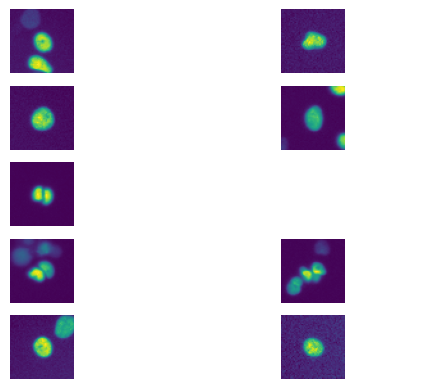

[(13, 243), (120, 84), (132, 199), (141, 206), (260, 241)]


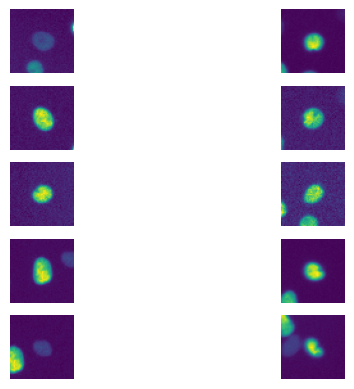

[(32, 236), (33, 23), (63, 238), (69, 79), (100, 155)]


c:\Users\rz200\Documents\development\cellprobabilityUNet\cellmask\centersdisplaying.py:164: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(crops[i])


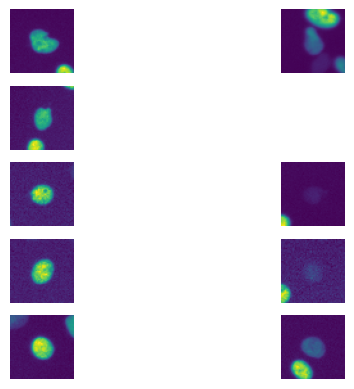

[(119, 28), (171, 21), (180, 250), (211, 215), (259, 239)]


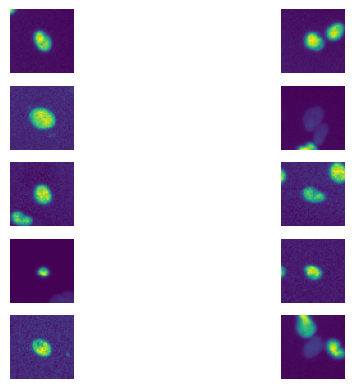

[(17, 105), (26, 178), (41, 7), (43, 220), (51, 5)]


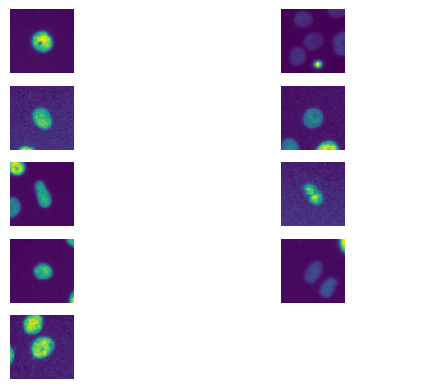

[(53, 11), (56, 67), (66, 93), (123, 121), (126, 118)]


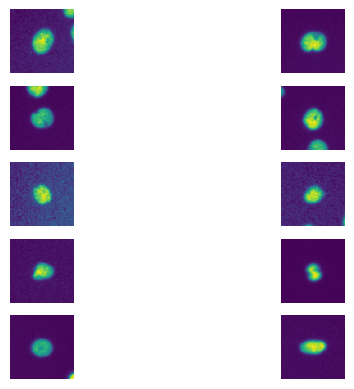

[(127, 171), (133, 26), (137, 145), (157, 128), (178, 166)]


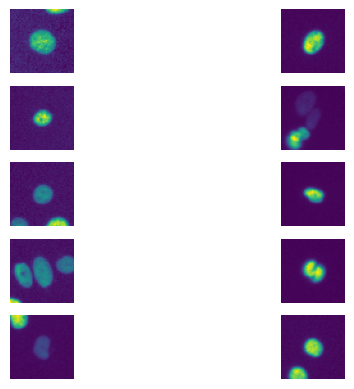

[(186, 164), (4, 47), (11, 75), (29, 148), (31, 35)]


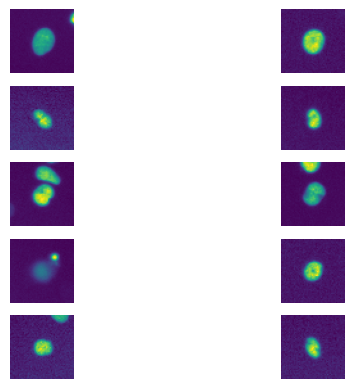

[(35, 240), (37, 122), (61, 254), (89, 13), (91, 4)]


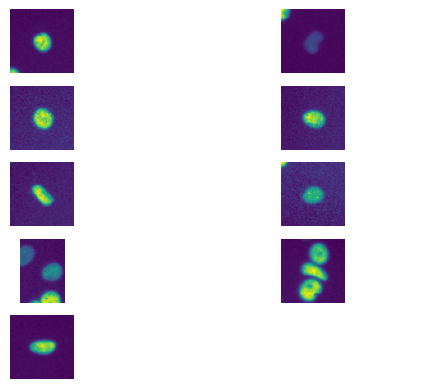

[(112, 219), (131, 32), (149, 27), (165, 55), (218, 8)]


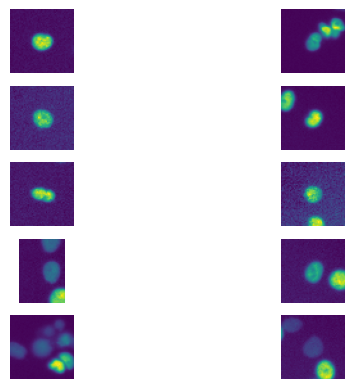

[(231, 138), (237, 87), (39, 141), (50, 112), (57, 124)]


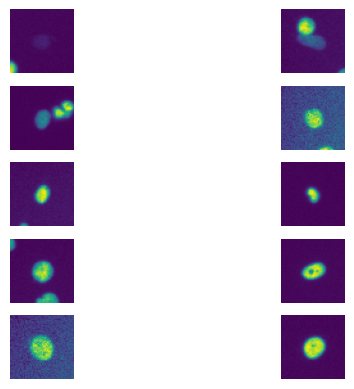

[(60, 15), (67, 96), (73, 163), (102, 53), (116, 6)]


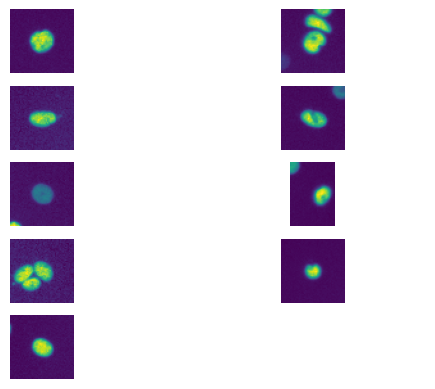

[(136, 1), (140, 103), (163, 41), (169, 194), (190, 16)]


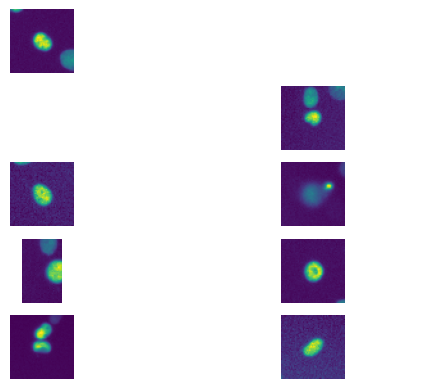

[(236, 50), (245, 9), (250, 205), (251, 72), (2, 42)]


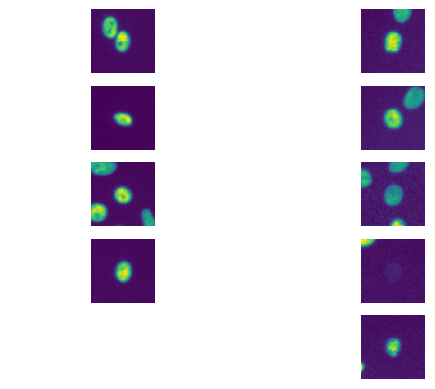

[(3, 62), (21, 39), (38, 172), (48, 224), (62, 83)]


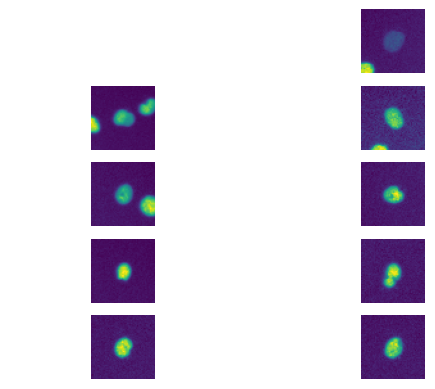

[(87, 233), (88, 45), (108, 248), (125, 119), (158, 52)]


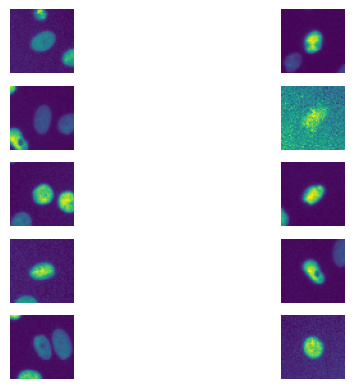

[(161, 218), (164, 127), (174, 190), (177, 226), (226, 142)]


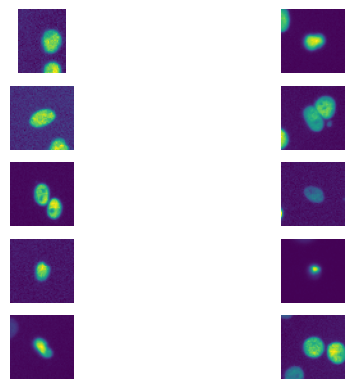

[(240, 152), (254, 60), (255, 31), (256, 44), (261, 40)]


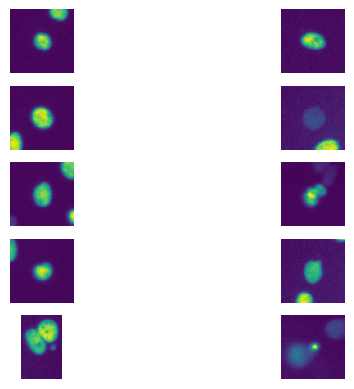

[(23, 33), (40, 51), (52, 20), (74, 68), (86, 167)]


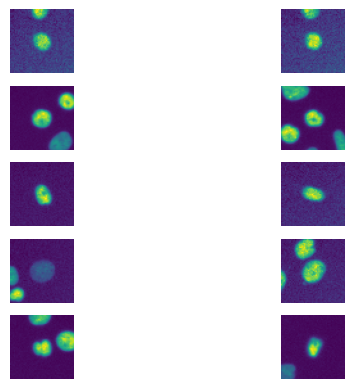

[(105, 18), (111, 10), (115, 115), (122, 17), (134, 76)]


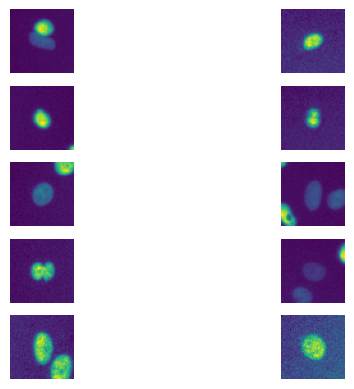

[(135, 22), (151, 196), (154, 261), (187, 133), (189, 77)]


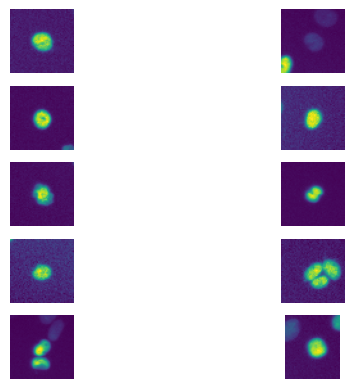

[(192, 182), (203, 255), (206, 116), (210, 200), (217, 111)]


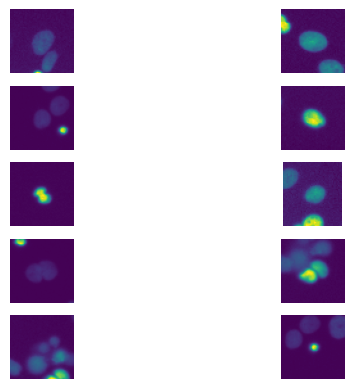

[(219, 34), (228, 159), (229, 24), (230, 237), (14, 56)]


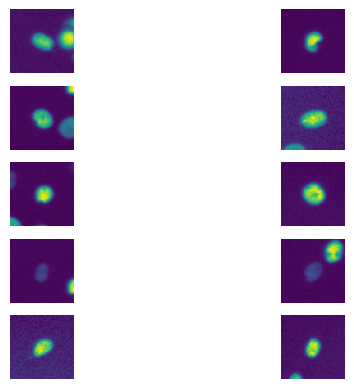

[(18, 150), (24, 140), (36, 244), (42, 12), (44, 74)]


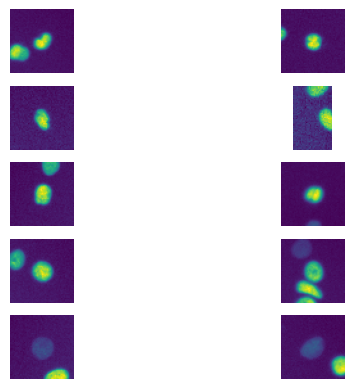

[(54, 37), (76, 242), (78, 162), (90, 29), (95, 131)]


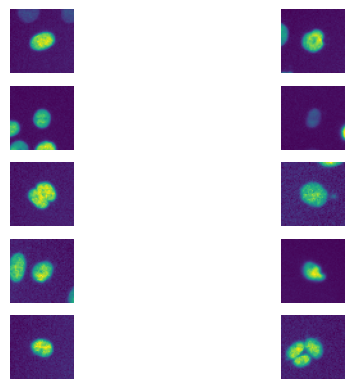

[(110, 174), (118, 107), (129, 137), (150, 211), (152, 101)]


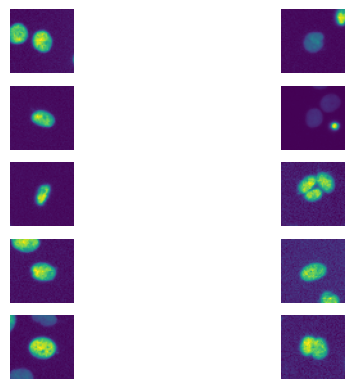

[(153, 134), (179, 192), (185, 184), (196, 30), (204, 214)]


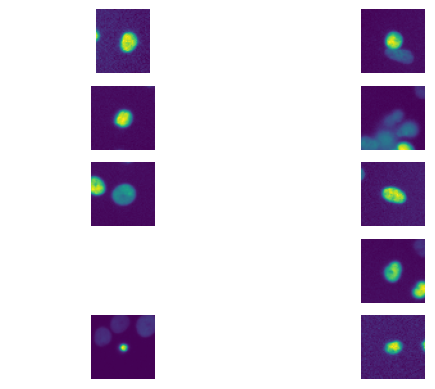

[(221, 195), (227, 90), (233, 183), (252, 153), (264, 70)]


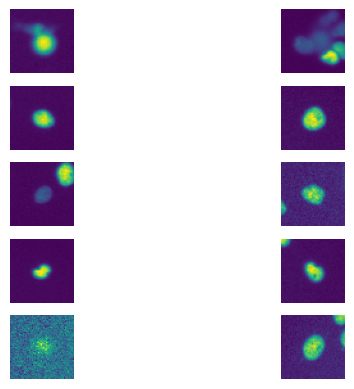

[(1, 235), (7, 209), (64, 104), (65, 198), (83, 139)]


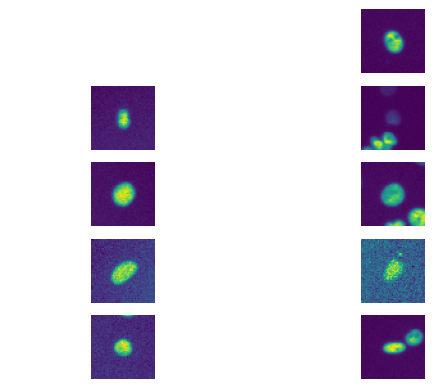

[(94, 230), (96, 221), (113, 43), (147, 92), (155, 228)]


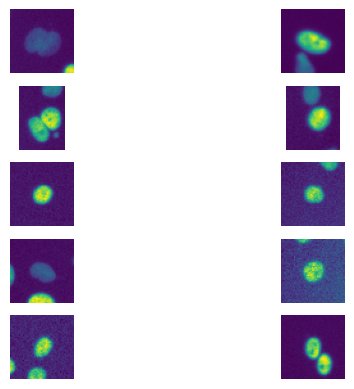

[(162, 38), (172, 175), (182, 25), (183, 136), (191, 126)]


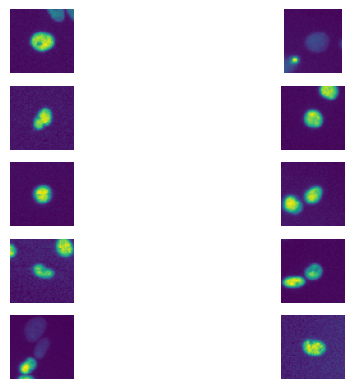

[(195, 168), (200, 86), (202, 204), (205, 46), (212, 73)]


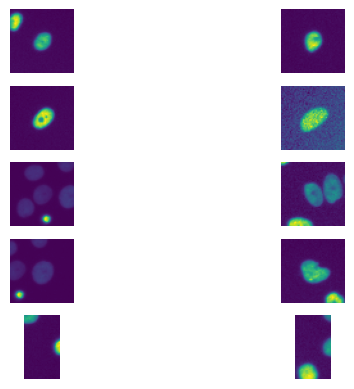

[(214, 59), (238, 144), (239, 223), (5, 61), (9, 54)]


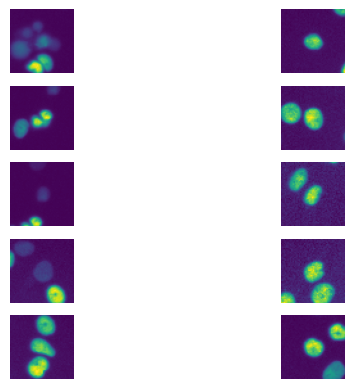

[(20, 64), (27, 80), (47, 187), (72, 247), (98, 14)]


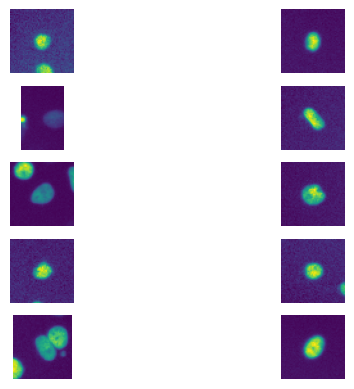

[(104, 161), (109, 210), (117, 3), (124, 201), (130, 154)]


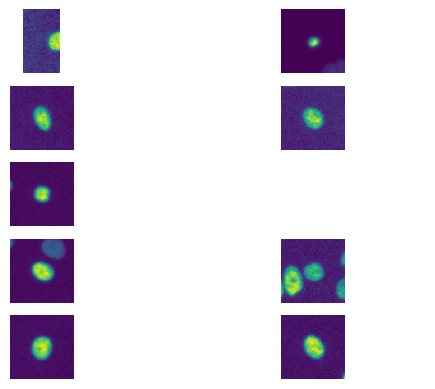

[(142, 89), (144, 88), (181, 232), (198, 160), (201, 193)]


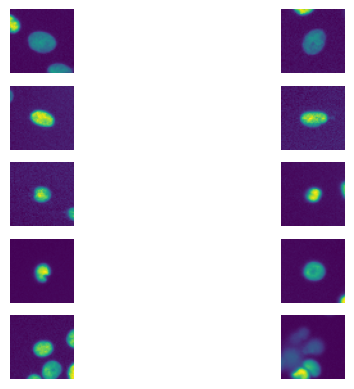

[(220, 165), (232, 19), (246, 170), (0, 97), (25, 36)]


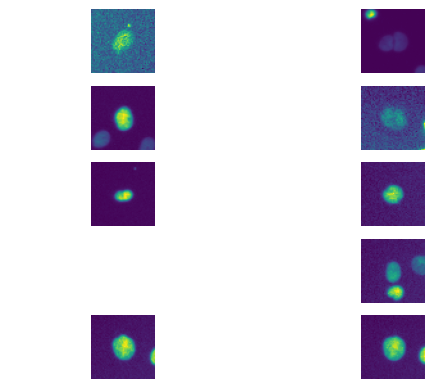

[(59, 173), (71, 81), (80, 177), (82, 99), (85, 186)]


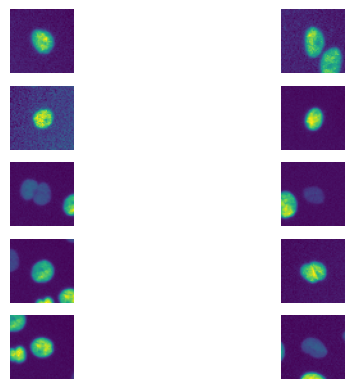

[(148, 180), (156, 102), (222, 185), (223, 123), (225, 222)]


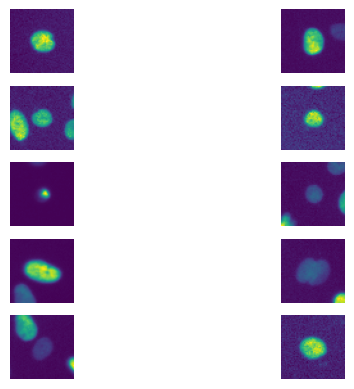

[(242, 179), (244, 229), (247, 197), (10, 227), (16, 213)]


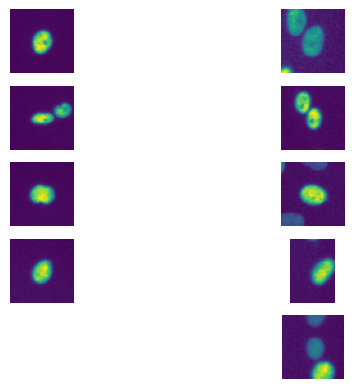

[(28, 202), (45, 117), (46, 71), (49, 91), (70, 231)]


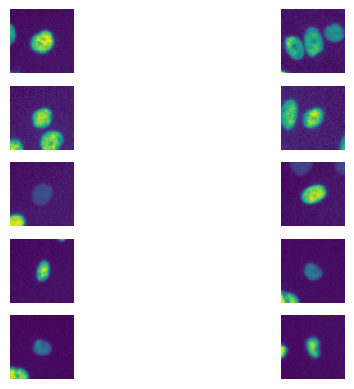

[(79, 57), (84, 49), (92, 94), (101, 66), (121, 203)]


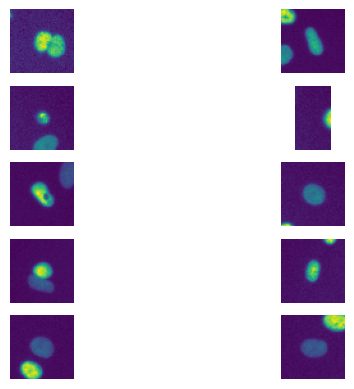

In [109]:
for i in range(0,len(pairs_1)-5,5):
    print(pairs_1[i:i+5])
    display_matches(pairs_1[i:i+5], cell_centers, images, size_of_crop=50)

In [98]:
print(np.unique(cos_sims_per_cell_masks_encFeats_cp))

[-0.46875 -0.4375  -0.40625 -0.375   -0.34375 -0.3125  -0.28125 -0.25
 -0.21875 -0.1875  -0.15625 -0.125   -0.09375 -0.0625  -0.03125  0.
  0.03125  0.0625   0.09375  0.125    0.15625  0.1875   0.21875  0.25
  0.28125  0.3125   0.34375  0.375    0.40625  0.4375   0.46875  0.5    ]


In [78]:
print(len(encFeats_per_cell_per_mask_mk[0]))
print(cell_centers[0][0])

267
(4.113475177304965, 955.4113475177305)


(3, 1280, 1280)


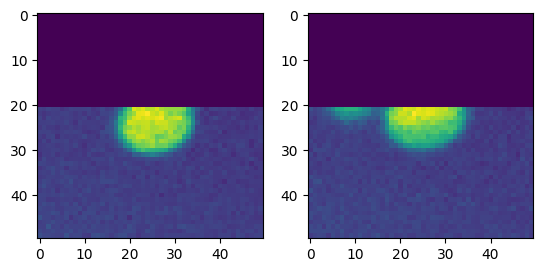

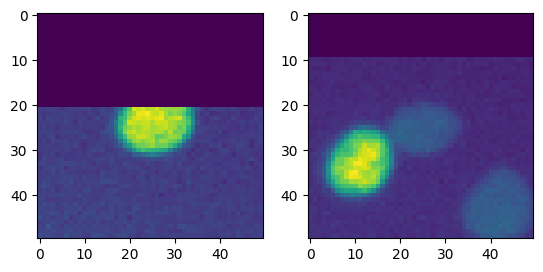

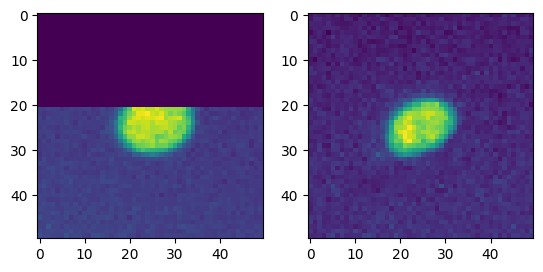

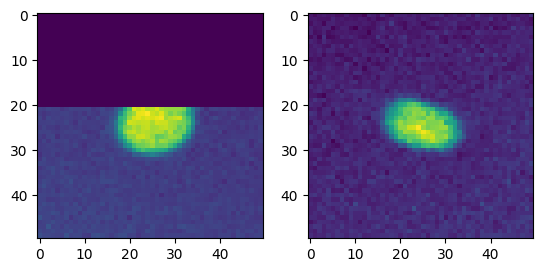

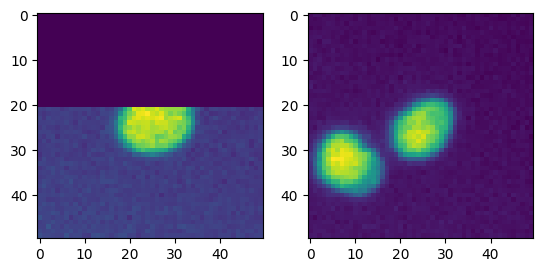

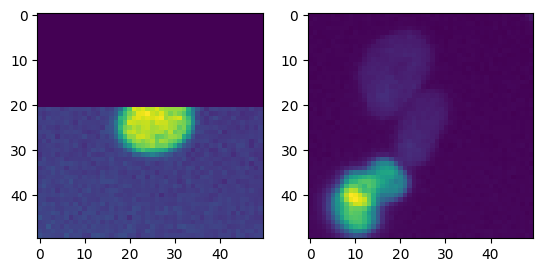

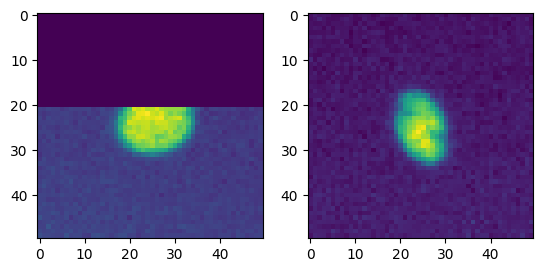

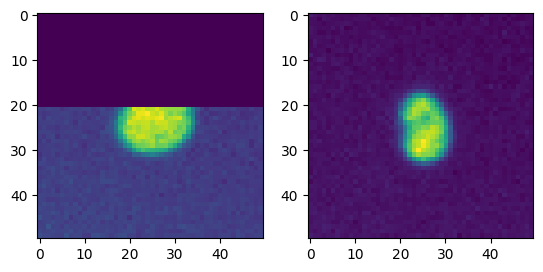

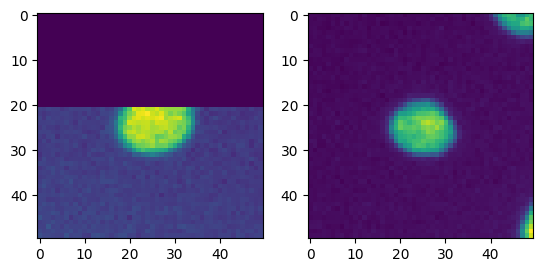

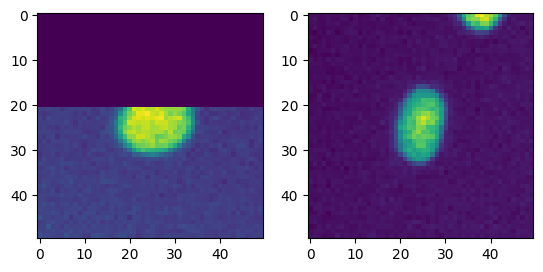

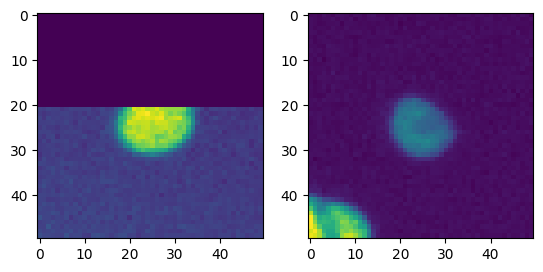

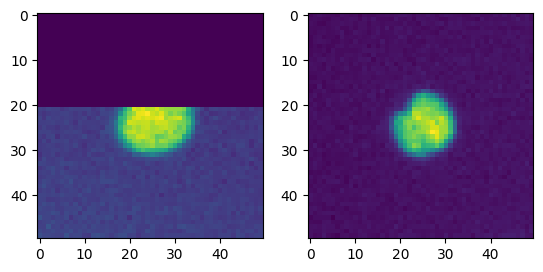

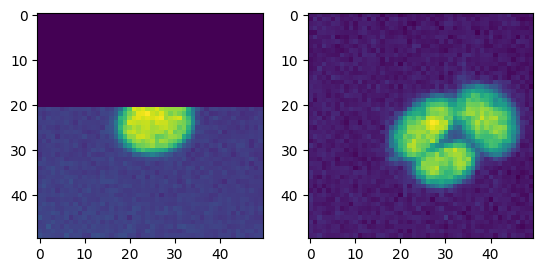

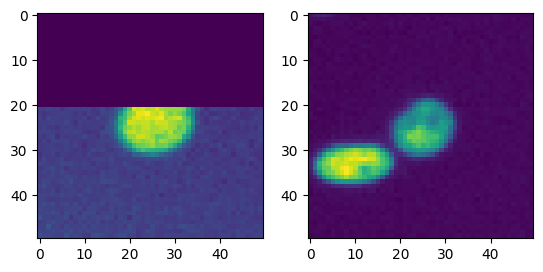

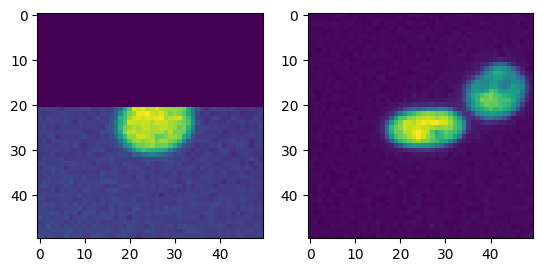

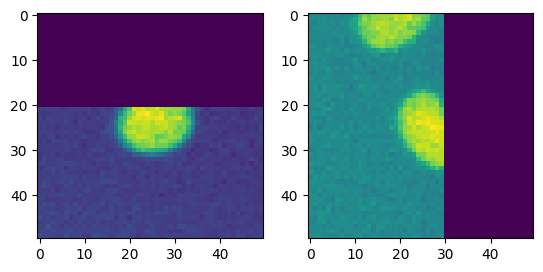

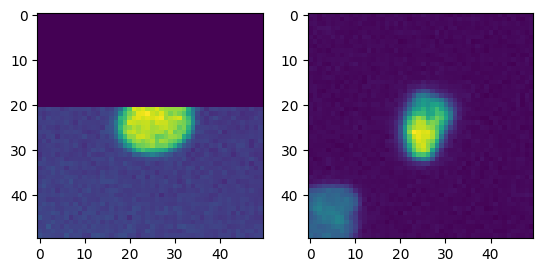

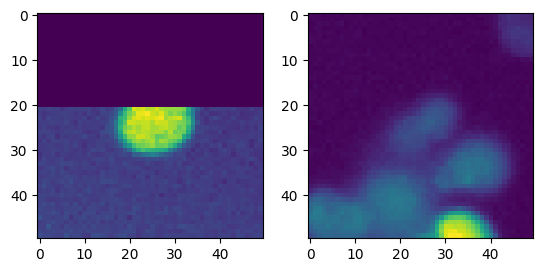

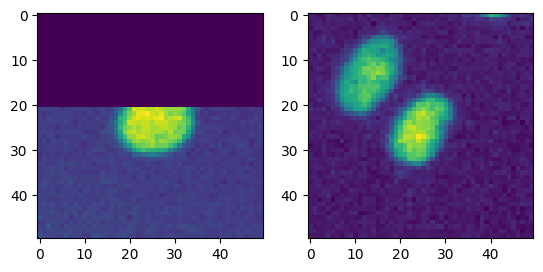

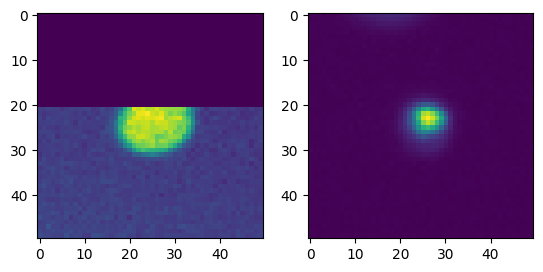

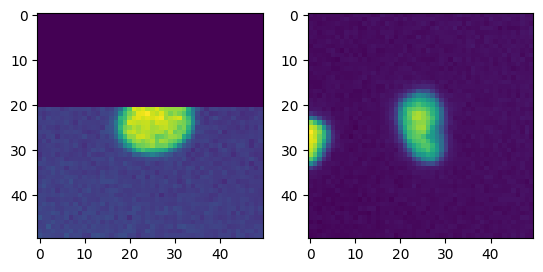

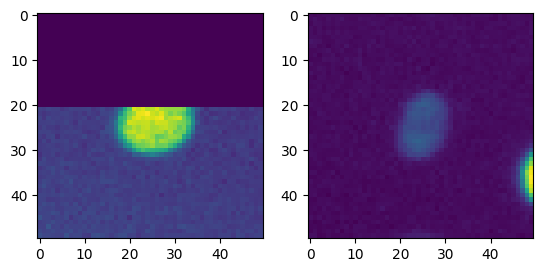

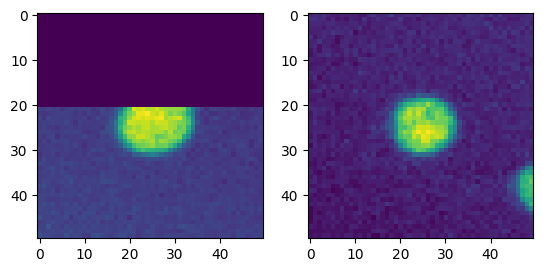

In [56]:
first_image_ci = 0

images_padded = np.array([np.pad(image, (100,100), 'constant') for image in images])
print(images_padded.shape)
for i in range(len(cos_sims_per_cell_masks_encFeats_mean[first_image_ci])):
    ele = cos_sims_per_cell_masks_encFeats_mean[first_image_ci][i]
    if ele == 1.0:
        cell_index = first_image_ci
        cell_center = (round(cell_centers[0][cell_index][0]),round(cell_centers[0][cell_index][1]))
        crop = images_padded[0][cell_center[0]-25+100:cell_center[0]+25+100, cell_center[1]-25+100:cell_center[1]+25+100]
        plt.subplot(1,2,1)
        plt.imshow(crop)

        cell_index = i
        cell_center = (round(cell_centers[1][cell_index][0]),round(cell_centers[1][cell_index][1]))
        crop = images_padded[1][cell_center[0]-25+100:cell_center[0]+25+100, cell_center[1]-25+100:cell_center[1]+25+100]

        plt.subplot(1,2,2)
        plt.imshow(crop)

        plt.show()